# Deep Learning

## HW4- Problem 3 


1.   Full Name: Mohammad Kalbasi
2.   Student Number: 401211028

references:
https://huggingface.co/HooshvareLab/bert-fa-base-uncased-sentiment-digikala
https://huggingface.co/spaces/evaluate-metric/perplexity
https://stackoverflow.com/questions/59209086/calculate-perplexity-in-pytorch

In [1]:
!pip install transformers
from transformers import AutoConfig, AutoTokenizer, AutoModel
import base64
import requests
import numpy as np
import gdown
from zipfile import ZipFile
import os

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
import re
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import random
from torch.utils.data import Dataset,DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchsummary import summary
import time
import os
import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.0 MB/s eta 0:00:00


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
!git clone https://github.com/amnghd/Persian_poems_corpus

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 10.52 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (148/148), done.


### Part A: linear tuning
in part A we just add a linear layer on top of transformer and we only train that layer, but for loading data we have two options, normalized or with stop words removed, in normalized version we have all the words and theoritically, it seems that we need all words to undrestand rhytme and style of poet, so first we train two models for this two different conditions and then find which one is better, and then from that point forward we use dataset which we achived higher accuracy wtih.

first lets try normalized text

In [5]:
with open('/content/Persian_poems_corpus/normalized/hafez_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  hafez = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/ferdousi_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  ferdousi = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/bidel_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  bidel = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/iqbal_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  iqbal = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/amir_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  amir = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/vahshi_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  vahshi = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/saeb_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  saeb = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/khajoo_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  khajoo = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/bahar_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  bahar = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/moulavi_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  moulavi = [line for line in lines if line]

we define bayt creator, we want to have (nearly) equal number of samples for each poet, so we define max_len, which is maximum length of output data so this way we can force our data to have same number of samples

In [6]:
def beyt_creator(poem_list,start_line,assigned_label,max_len):
  """
  create list of "beyts" of poem
  inputs:
    poem_list: list of poem
    start_line: index of list where poem starts
    assigned_label: assigned label for classification
    max_len: maximum length of output data
  """
  poem_len = len(poem_list)
  out_poem = []
  poem_label = []
  for i in range(start_line,poem_len-1,2):
    temp_beyt = poem_list[i] + " " + poem_list[i+1]
    out_poem.append(temp_beyt)
    poem_label.append(int(assigned_label))
  if len(poem_label)>max_len:
    out_poem = out_poem[:max_len]
    poem_label = poem_label[:max_len]
  return out_poem,poem_label

In [7]:
out_poem0,poem_label0 = beyt_creator(hafez,1,0,5000)
out_poem1,poem_label1 = beyt_creator(ferdousi,1,1,5000)
out_poem2,poem_label2 = beyt_creator(bidel,1,2,5000)
out_poem3,poem_label3 = beyt_creator(iqbal,1,3,5000)
out_poem4,poem_label4 = beyt_creator(amir,1,4,5000)
out_poem5,poem_label5 = beyt_creator(vahshi,1,5,5000)
out_poem6,poem_label6 = beyt_creator(saeb,1,6,5000)
out_poem7,poem_label7 = beyt_creator(khajoo,1,7,5000)
out_poem8,poem_label8 = beyt_creator(bahar,1,8,5000)
out_poem9,poem_label9 = beyt_creator(moulavi,1,9,5000)
out_poem = out_poem0 + out_poem1 + out_poem2 + out_poem3 + out_poem4 + out_poem5 + out_poem6 + out_poem7 + out_poem8 + out_poem9
poem_label = poem_label0 + poem_label1 + poem_label2 + poem_label3 + poem_label4 + poem_label5 + poem_label6 + poem_label7 + poem_label8 + poem_label9




In [43]:
temp = list(zip(out_poem, poem_label))
random.shuffle(temp)
X, y = zip(*temp)

we splited data to train, test and validation, to be honest we don't need both test and validation because we only add one layer (with fixed output length) but because in next part we use different kinds of optimizers(and it have different effect on accuracy for validation data) we can say that we need validation to find best optimizer and use test data after,

In [44]:
X_train_all = X[0:int(0.8*len(X))]
y_train_all = y[0:int(0.8*len(y))]
X_train = X_train_all[0:int(0.9*len(X_train_all))]
y_train = y_train_all[0:int(0.9*len(X_train_all))]
X_valid = X_train_all[int(0.9*len(X_train_all)):]
y_valid = y_train_all[int(0.9*len(X_train_all)):]
X_test = X[int(0.8*len(X)):]
y_test = y[int(0.8*len(X)):]

looking at labels distrinution

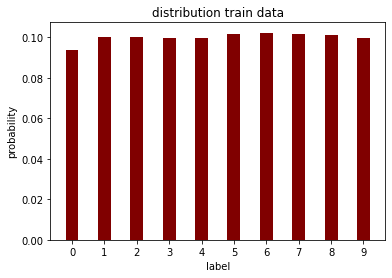

In [10]:
train_dist = np.zeros(10,)
test_dist = np.zeros(10,)
valid_dist = np.zeros(10,)
orig_dist = np.zeros(10,)
for i in range(10):
  temp= np.sum(np.asarray(y_train) == i)
  train_dist[i]  = temp
  temp= np.sum(np.asarray(y) == i)
  orig_dist[i] = temp

label_list = ['0','1','2','3','4','5','6','7','8','9']
values = train_dist/np.sum(train_dist) # normalizing sum to make it probability
plt.bar(label_list, values, color ='maroon',width = 0.4)
 
plt.xlabel("label")
plt.ylabel("probability")
plt.title("distribution train data")
plt.show()

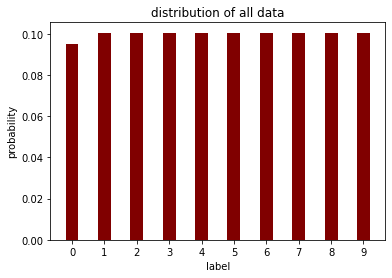

In [11]:
values = orig_dist/np.sum(orig_dist) # normalizing sum to make it probability
plt.bar(label_list, values, color ='maroon',width = 0.4)
 
plt.xlabel("label")
plt.ylabel("probability")
plt.title("distribution of all data")
plt.show()

as we can see, we have same number of samples for different poets(expect first one(hafez, but because I love hafez i couldn't bring myself to replace him with another poet)  because it has less samples than max_len that we defined)

loading our transformer

In [12]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
tokenizer.tokenize(X[30])


['کو',
 'پیک',
 'صبح',
 'تا',
 'گله',
 'های',
 'شب',
 'فراق',
 'با',
 'ان',
 'خجسته',
 'طالع',
 'فرخنده',
 'پی',
 'کنم']

In [14]:
#finding max length
len_max = 0;
for i in range(len(X)):
  x_temp = X[i].split()
  if len(x_temp)>len_max:
    len_max = len(x_temp)
print(f"maximum length = {len_max}")
# now tokenizing based of max length we find
encoding = tokenizer.encode_plus(
    X[32],
    max_length=len_max+2,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

maximum length = 26
Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2, 19444,  2789, 69424,  1379,  9689,  2789,  4776,  2787, 14456,
         13101,  2806,  1379, 12320,  2806, 11262,     4,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])


In [15]:
MAX_LEN = len_max + 2
BATCH_SIZE = 16

define our data loader

In [16]:
class poet_dataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, data,labels, max_len=128):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        poet = str(self.data[item])

       
        target = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            poet,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'poet': poet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            
        }

       
        inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs



In [17]:
dataset = poet_dataset(
        data=X_train,
        labels=y_train,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
train_data_loader = DataLoader(dataset,batch_size = 16,shuffle = True)
print(f"number batches in train = {len(train_data_loader)}")
dataset = poet_dataset(
        data=X_valid,
        labels=y_valid,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
valid_data_loader = DataLoader(dataset,batch_size = 16,shuffle = False)
print(f"number batches in validation = {len(valid_data_loader)}")

dataset = poet_dataset(
        data=X_test,
        labels=y_test,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
test_data_loader = DataLoader(dataset,batch_size = 16,shuffle = False)


number batches in train = 2238
number batches in validation = 249


In [18]:
#testing dataloader
sample_data = next(iter(train_data_loader))
print(sample_data.keys())

print(sample_data['poet'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])


dict_keys(['poet', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['بر طرف چمن شاخ درختان ز شکوفه مانند بت سیمبر مشک عذارست', 'هرگزم نقش تو از لوح دل و جان نرود هرگز از یاد من آن سرو خرامان نرود', 'مالد به قصر و بر در و دیوار خویشتن گویی ز فرق تا قد مش  گر و دمل است', 'بی خط تو سر نامه سودا نتوان خواند بی زلف تو سر در سر سودا نتوان کرد', 'زگریه خاک جهان بی تو داده ایم به باد هنوز چون مژه ها می زنیم چنگ درآب', 'محکوم حرص و پاس مراتب چه ممکن است با شرم کار نیست زبان سوال را', 'ایران کهن شده است سراپای درمانش جز به تازه شدن نیست', 'گذشت بر من مسکین و با رقیبان گفت دریغ حافظ مسکین من چه جانی داد', 'چه قیامت است جانا که به عاشقان نمودی دل و جان فدای رویت بنما عذار ما را', 'دل رهروان فریبی به کلام نیش داری مگر اینکه لذت او نرسد به نوک خاری', 'آن گمره زرق دله محتال  وین فتنه برق عینک دلبر', 'تیر هرگز نشنیدم که  کند فعل سپر تیر او خلق جهان را ز بلاها سپرست', 'شاعر اندر سینه ملت چو دل ملتی بی شاعری انبار گل', 'ز های و هوی غریوش هزار دل چو دلم بر آتش غم و تیمار بیش  گشته کباب', 'یا

In [19]:
# getting model configuration
from transformers import BertConfig, BertTokenizer,BertModel


labels = ['hafez','ferdousi','bidel','iqbal','amir','vahshi','saeb','khajoo','bahar','moulavi']
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')
MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

label2id: {'hafez': 0, 'ferdousi': 1, 'bidel': 2, 'iqbal': 3, 'amir': 4, 'vahshi': 5, 'saeb': 6, 'khajoo': 7, 'bahar': 8, 'moulavi': 9}
id2label: {0: 'hafez', 1: 'ferdousi', 2: 'bidel', 3: 'iqbal', 4: 'amir', 5: 'vahshi', 6: 'saeb', 7: 'khajoo', 8: 'bahar', 9: 'moulavi'}
{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "hafez",
    "1": "ferdousi",
    "2": "bidel",
    "3": "iqbal",
    "4": "amir",
    "5": "vahshi",
    "6": "saeb",
    "7": "khajoo",
    "8": "bahar",
    "9": "moulavi"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "amir": 4,
    "bahar": 8,
    "bidel": 2,
    "ferdousi": 1,
    "hafez": 0,
    "iqbal": 3,
    "khajoo": 7,
    "moulavi": 9,
    "saeb": 6,
    "vahshi": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",


for defining model, we define fine_tune parameter, if its true, we allow transformer to be involved in train process, but if its false we only fine tune linear layer ( and freeze transformer weights), for part A we use second method to only train linear layer

In [20]:
from torch import nn
class Poet_Bert_classifier(nn.Module):

    def __init__(self, config,MODEL_NAME_OR_PATH,fine_tune):
        super(Poet_Bert_classifier, self).__init__()

        bert_model = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        if (fine_tune):
          self.bert = bert_model
        else:
          for param in bert_model.parameters():
            param.requires_grad = False
          self.bert = bert_model
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, token_type_ids=token_type_ids,return_dict=False)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [21]:
pt_model = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = False )
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


In [ ]:
pytorch_total_params = sum(p.numel() for p in pt_model.parameters())
print(f"number of all parameters in model {pytorch_total_params}")
pytorch_total_params = sum(p.numel() for p in pt_model.parameters() if p.requires_grad)
print(f"number of trainable parameters in model {pytorch_total_params}")


number of all parameters in model 162849034
number of trainable parameters in model 7690


as we can see, we only have 7690 trainable parameter so in this case we just fine tune linear layer

In [ ]:

sample_data_poet = sample_data['poet']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)




outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(outputs[:5, :])
print(preds[:5])

tensor([[-0.1372,  0.2707, -0.4495,  0.4449, -0.7266,  0.4119, -0.2000, -0.4184,
          0.0915,  0.4978],
        [-0.0439,  0.6669, -0.0528,  0.2207, -0.4717,  0.1205, -0.1659, -0.2691,
          0.3662,  0.0064],
        [-0.1181,  0.1615, -0.4056,  0.1816, -0.5724,  0.2286, -0.1090, -0.1351,
          0.1988,  0.0679],
        [-0.1354,  0.2366, -0.4773,  0.4017, -0.9289,  0.3154, -0.3524, -0.1143,
          0.4461,  0.0192],
        [-0.0603,  0.4829, -0.1939, -0.0049, -0.8043,  0.1390, -0.2564, -0.4613,
          0.2636,  0.3570]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([9, 1, 5, 8, 1], device='cuda:0')


In [ ]:
def train_model_manual(model, criterion, optimizer,scheduler,val_beark,clip, num_epochs=25):
  """
  function for train our model! in this function we use dataloader directly.
  inputs: 
      model: input model 
      criterion: desired loss function
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
      clip: for gradient clipping
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for dl in tqdm(train_data_loader, total=len(train_data_loader), desc="Training... "):
      # 1. Forward pass
      input_ids = dl['input_ids']
      attention_mask = dl['attention_mask']
      token_type_ids = dl['token_type_ids']
      targets = dl['targets']
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      token_type_ids = token_type_ids.to(device)
      targets = targets.to(device)
 
      outputs = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = criterion(outputs, targets)
      acc_train += torch.sum(preds == targets.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()
      if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/counter
    acc_train = acc_train/len(X_train)
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for dl in tqdm(valid_data_loader, total=len(valid_data_loader), desc="Validating... "):
      # 1. Forward pass
        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
        _, preds = torch.max(outputs, 1)
        loss_test= criterion(outputs, targets.data)
        acc_test += torch.sum(preds == targets.data)
      loss_test = loss_test/counter
      acc_test = acc_test/len(X_valid)
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(pt_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model = pt_model.to(device)
pt_model_trained,best_loss,best_acc = train_model_manual(pt_model, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,num_epochs=20)

Validating... : 100%|██████████| 249/249 [00:06<00:00, 37.19it/s]


Epoch: 0 | Loss: 2.04523, Acc: 0.27% | Test Loss: 1.77942, Test Acc: 0.35%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.11it/s]


Epoch: 1 | Loss: 1.88982, Acc: 0.33% | Test Loss: 1.74580, Test Acc: 0.37%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 35.91it/s]


Epoch: 2 | Loss: 1.84349, Acc: 0.35% | Test Loss: 1.55632, Test Acc: 0.39%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.15it/s]


Epoch: 3 | Loss: 1.81332, Acc: 0.36% | Test Loss: 1.54100, Test Acc: 0.39%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.28it/s]


Epoch: 4 | Loss: 1.80168, Acc: 0.37% | Test Loss: 1.73374, Test Acc: 0.40%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.21it/s]


Epoch: 5 | Loss: 1.78917, Acc: 0.37% | Test Loss: 1.64024, Test Acc: 0.40%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.38it/s]


Epoch: 6 | Loss: 1.77541, Acc: 0.37% | Test Loss: 1.47460, Test Acc: 0.39%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.19it/s]


Epoch: 7 | Loss: 1.76490, Acc: 0.38% | Test Loss: 1.57522, Test Acc: 0.40%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.15it/s]


Epoch: 8 | Loss: 1.75631, Acc: 0.38% | Test Loss: 1.62872, Test Acc: 0.41%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.08it/s]


Epoch: 9 | Loss: 1.75122, Acc: 0.38% | Test Loss: 1.69776, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.07it/s]


Epoch: 10 | Loss: 1.75342, Acc: 0.38% | Test Loss: 1.66009, Test Acc: 0.41%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 35.97it/s]


Epoch: 11 | Loss: 1.74653, Acc: 0.39% | Test Loss: 1.33195, Test Acc: 0.41%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.15it/s]


Epoch: 12 | Loss: 1.74434, Acc: 0.39% | Test Loss: 1.49750, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.02it/s]


Epoch: 13 | Loss: 1.73961, Acc: 0.39% | Test Loss: 1.40092, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.18it/s]


Epoch: 14 | Loss: 1.73506, Acc: 0.39% | Test Loss: 1.49037, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.15it/s]


Epoch: 15 | Loss: 1.73340, Acc: 0.39% | Test Loss: 1.71937, Test Acc: 0.40%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.01it/s]


Epoch: 16 | Loss: 1.72990, Acc: 0.40% | Test Loss: 1.65474, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.12it/s]


Epoch: 17 | Loss: 1.73425, Acc: 0.39% | Test Loss: 1.44215, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.20it/s]


Epoch: 18 | Loss: 1.73225, Acc: 0.39% | Test Loss: 1.40835, Test Acc: 0.41%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.18it/s]


Epoch: 19 | Loss: 1.72946, Acc: 0.39% | Test Loss: 1.45706, Test Acc: 0.42%
Training complete in 23m 13s
Best val Acc: 0.424837


now testing it when using stop words removed and compare result

In [ ]:
with open('/content/Persian_poems_corpus/stop words removed/hafez_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  hafez = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/ferdousi_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  ferdousi = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/bidel_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  bidel = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/iqbal_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  iqbal = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/amir_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  amir = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/vahshi_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  vahshi = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/saeb_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  saeb = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/khajoo_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  khajoo = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/bahar_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  bahar = [line for line in lines if line]
with open('/content/Persian_poems_corpus/stop words removed/moulavi_stp_rmv.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  moulavi = [line for line in lines if line]

In [ ]:
out_poem0,poem_label0 = beyt_creator(hafez,1,0,5000)
out_poem1,poem_label1 = beyt_creator(ferdousi,1,1,5000)
out_poem2,poem_label2 = beyt_creator(bidel,1,2,5000)
out_poem3,poem_label3 = beyt_creator(iqbal,1,3,5000)
out_poem4,poem_label4 = beyt_creator(amir,1,4,5000)
out_poem5,poem_label5 = beyt_creator(vahshi,1,5,5000)
out_poem6,poem_label6 = beyt_creator(saeb,1,6,5000)
out_poem7,poem_label7 = beyt_creator(khajoo,1,7,5000)
out_poem8,poem_label8 = beyt_creator(bahar,1,8,5000)
out_poem9,poem_label9 = beyt_creator(moulavi,1,9,5000)
out_poem = out_poem0 + out_poem1 + out_poem2 + out_poem3 + out_poem4 + out_poem5 + out_poem6 + out_poem7 + out_poem8 + out_poem9
poem_label = poem_label0 + poem_label1 + poem_label2 + poem_label3 + poem_label4 + poem_label5 + poem_label6 + poem_label7 + poem_label8 + poem_label9




In [ ]:
temp = list(zip(out_poem, poem_label))
random.shuffle(temp)
X, y = zip(*temp)

In [ ]:
X_train_all = X[0:int(0.8*len(X))]
y_train_all = y[0:int(0.8*len(y))]
X_train = X_train_all[0:int(0.9*len(X_train_all))]
y_train = y_train_all[0:int(0.9*len(X_train_all))]
X_valid = X_train_all[int(0.9*len(X_train_all)):]
y_valid = y_train_all[int(0.9*len(X_train_all)):]
X_test = X[int(0.8*len(X)):]
y_test = y[int(0.8*len(X)):]

In [ ]:
dataset = poet_dataset(
        data=X_train,
        labels=y_train,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
train_data_loader = DataLoader(dataset,batch_size = 16,shuffle = True)
print(f"number batches in train = {len(train_data_loader)}")
dataset = poet_dataset(
        data=X_valid,
        labels=y_valid,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
valid_data_loader = DataLoader(dataset,batch_size = 16,shuffle = False)
print(f"number batches in validation = {len(valid_data_loader)}")

dataset = poet_dataset(
        data=X_test,
        labels=y_test,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
test_data_loader = DataLoader(dataset,batch_size = 16,shuffle = False)


number batches in train = 2237
number batches in validation = 249


In [ ]:
dataset[1]

{'poet': 'شورش رستخیز منست مغز پشنگ شتاب',
 'input_ids': tensor([    2,  8155,  5005, 10377,  9023,  2009,  5368, 56531,  8099,     4,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 'targets': tensor(1)}

In [ ]:
pt_model = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = False )
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(pt_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model = pt_model.to(device)
pt_model_trained_stp_rmv,best_loss,best_acc = train_model_manual(pt_model, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,num_epochs=20)

Validating... : 100%|██████████| 249/249 [00:07<00:00, 34.88it/s]


Epoch: 0 | Loss: 2.13938, Acc: 0.22% | Test Loss: 2.01426, Test Acc: 0.25%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.17it/s]


Epoch: 1 | Loss: 2.02523, Acc: 0.28% | Test Loss: 1.71349, Test Acc: 0.32%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.30it/s]


Epoch: 2 | Loss: 1.99334, Acc: 0.29% | Test Loss: 1.71403, Test Acc: 0.33%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.04it/s]


Epoch: 3 | Loss: 1.97456, Acc: 0.30% | Test Loss: 1.61894, Test Acc: 0.34%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.09it/s]


Epoch: 4 | Loss: 1.96235, Acc: 0.30% | Test Loss: 1.48459, Test Acc: 0.33%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.21it/s]


Epoch: 5 | Loss: 1.95370, Acc: 0.31% | Test Loss: 1.61490, Test Acc: 0.34%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.14it/s]


Epoch: 6 | Loss: 1.94578, Acc: 0.31% | Test Loss: 1.52308, Test Acc: 0.33%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.25it/s]


Epoch: 7 | Loss: 1.94139, Acc: 0.31% | Test Loss: 1.60109, Test Acc: 0.34%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.04it/s]


Epoch: 8 | Loss: 1.94000, Acc: 0.31% | Test Loss: 1.66763, Test Acc: 0.29%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.06it/s]


Epoch: 9 | Loss: 1.93590, Acc: 0.31% | Test Loss: 1.62614, Test Acc: 0.34%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.14it/s]


Epoch: 10 | Loss: 1.93175, Acc: 0.31% | Test Loss: 1.54741, Test Acc: 0.34%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.13it/s]


Epoch: 11 | Loss: 1.93446, Acc: 0.32% | Test Loss: 1.54501, Test Acc: 0.36%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.16it/s]


Epoch: 12 | Loss: 1.93195, Acc: 0.32% | Test Loss: 1.51574, Test Acc: 0.34%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.11it/s]


Epoch: 13 | Loss: 1.92859, Acc: 0.32% | Test Loss: 1.50382, Test Acc: 0.36%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.12it/s]


Epoch: 14 | Loss: 1.92968, Acc: 0.32% | Test Loss: 1.68096, Test Acc: 0.35%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.12it/s]


Epoch: 15 | Loss: 1.92427, Acc: 0.32% | Test Loss: 1.39678, Test Acc: 0.36%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.05it/s]


Epoch: 16 | Loss: 1.92350, Acc: 0.32% | Test Loss: 1.47382, Test Acc: 0.35%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.11it/s]


Epoch: 17 | Loss: 1.92376, Acc: 0.32% | Test Loss: 1.55320, Test Acc: 0.36%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.11it/s]


Epoch: 18 | Loss: 1.92644, Acc: 0.32% | Test Loss: 1.60201, Test Acc: 0.34%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 36.04it/s]


Epoch: 19 | Loss: 1.91974, Acc: 0.32% | Test Loss: 1.60333, Test Acc: 0.36%
Training complete in 23m 9s
Best val Acc: 0.361328


so as we can see, when we use "stop word removed" data results become much worse and that is logical, so from now on we use normalized dataset,
lets train model again and plot it confusion matrix

In [ ]:
with open('/content/Persian_poems_corpus/normalized/hafez_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  hafez = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/ferdousi_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  ferdousi = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/bidel_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  bidel = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/iqbal_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  iqbal = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/amir_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  amir = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/vahshi_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  vahshi = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/saeb_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  saeb = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/khajoo_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  khajoo = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/bahar_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  bahar = [line for line in lines if line]
with open('/content/Persian_poems_corpus/normalized/moulavi_norm.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  moulavi = [line for line in lines if line]

In [ ]:
out_poem0,poem_label0 = beyt_creator(hafez,1,0,5000)
out_poem1,poem_label1 = beyt_creator(ferdousi,1,1,5000)
out_poem2,poem_label2 = beyt_creator(bidel,1,2,5000)
out_poem3,poem_label3 = beyt_creator(iqbal,1,3,5000)
out_poem4,poem_label4 = beyt_creator(amir,1,4,5000)
out_poem5,poem_label5 = beyt_creator(vahshi,1,5,5000)
out_poem6,poem_label6 = beyt_creator(saeb,1,6,5000)
out_poem7,poem_label7 = beyt_creator(khajoo,1,7,5000)
out_poem8,poem_label8 = beyt_creator(bahar,1,8,5000)
out_poem9,poem_label9 = beyt_creator(moulavi,1,9,5000)
out_poem = out_poem0 + out_poem1 + out_poem2 + out_poem3 + out_poem4 + out_poem5 + out_poem6 + out_poem7 + out_poem8 + out_poem9
poem_label = poem_label0 + poem_label1 + poem_label2 + poem_label3 + poem_label4 + poem_label5 + poem_label6 + poem_label7 + poem_label8 + poem_label9
temp = list(zip(out_poem, poem_label))
random.shuffle(temp)
X, y = zip(*temp)

X_train_all = X[0:int(0.8*len(X))]
y_train_all = y[0:int(0.8*len(y))]
X_train = X_train_all[0:int(0.9*len(X_train_all))]
y_train = y_train_all[0:int(0.9*len(X_train_all))]
X_valid = X_train_all[int(0.9*len(X_train_all)):]
y_valid = y_train_all[int(0.9*len(X_train_all)):]
X_test = X[int(0.8*len(X)):]
y_test = y[int(0.8*len(X)):]

In [ ]:
#finding max length
len_max = 0;
for i in range(len(X)):
  x_temp = X[i].split()
  if len(x_temp)>len_max:
    len_max = len(x_temp)
print(f"maximum length = {len_max}")
# now tokenizing based of max length we find
encoding = tokenizer.encode_plus(
    X[32],
    max_length=len_max+2,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

maximum length = 26
Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  2789, 10157,  4151,  2822,  2820,  2789, 10157,  2910,  2801,
          2882,  2800, 24753,  2799,  2861, 40878,  5303,  1379,  4313, 29365,
          2964,     4,     0,     0,     0,     0,     0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0]])


In [ ]:
dataset = poet_dataset(
        data=X_train,
        labels=y_train,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
train_data_loader = DataLoader(dataset,batch_size = 16,shuffle = True)
print(f"number batches in train = {len(train_data_loader)}")
dataset = poet_dataset(
        data=X_valid,
        labels=y_valid,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
valid_data_loader = DataLoader(dataset,batch_size = 16,shuffle = False)
print(f"number batches in validation = {len(valid_data_loader)}")

dataset = poet_dataset(
        data=X_test,
        labels=y_test,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
test_data_loader = DataLoader(dataset,batch_size = 16,shuffle = False)


number batches in train = 2238
number batches in validation = 249


In [ ]:
pt_model = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = False )
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(pt_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model = pt_model.to(device)
pt_model_trained_linear_tune,best_loss,best_acc = train_model_manual(pt_model, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,num_epochs=20)

Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.66it/s]


Epoch: 0 | Loss: 2.04916, Acc: 0.26% | Test Loss: 1.95225, Test Acc: 0.32%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.66it/s]


Epoch: 1 | Loss: 1.89072, Acc: 0.33% | Test Loss: 1.80072, Test Acc: 0.38%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.26it/s]


Epoch: 2 | Loss: 1.85121, Acc: 0.35% | Test Loss: 1.67164, Test Acc: 0.40%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.26it/s]


Epoch: 3 | Loss: 1.82128, Acc: 0.36% | Test Loss: 1.67443, Test Acc: 0.40%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.17it/s]


Epoch: 4 | Loss: 1.79929, Acc: 0.37% | Test Loss: 1.67588, Test Acc: 0.38%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.19it/s]


Epoch: 5 | Loss: 1.78786, Acc: 0.37% | Test Loss: 1.69557, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.25it/s]


Epoch: 6 | Loss: 1.77807, Acc: 0.38% | Test Loss: 1.51627, Test Acc: 0.41%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.34it/s]


Epoch: 7 | Loss: 1.77503, Acc: 0.38% | Test Loss: 1.46183, Test Acc: 0.41%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.31it/s]


Epoch: 8 | Loss: 1.77252, Acc: 0.38% | Test Loss: 1.47013, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.37it/s]


Epoch: 9 | Loss: 1.76617, Acc: 0.38% | Test Loss: 1.36434, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.34it/s]


Epoch: 10 | Loss: 1.75787, Acc: 0.38% | Test Loss: 1.56353, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.35it/s]


Epoch: 11 | Loss: 1.74975, Acc: 0.38% | Test Loss: 1.45633, Test Acc: 0.40%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 37.63it/s]


Epoch: 12 | Loss: 1.74696, Acc: 0.38% | Test Loss: 1.41004, Test Acc: 0.44%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.27it/s]


Epoch: 13 | Loss: 1.74716, Acc: 0.39% | Test Loss: 1.41695, Test Acc: 0.43%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.27it/s]


Epoch: 14 | Loss: 1.74398, Acc: 0.39% | Test Loss: 1.65731, Test Acc: 0.43%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.28it/s]


Epoch: 15 | Loss: 1.73999, Acc: 0.39% | Test Loss: 1.44065, Test Acc: 0.44%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.24it/s]


Epoch: 16 | Loss: 1.74070, Acc: 0.39% | Test Loss: 1.52899, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.20it/s]


Epoch: 17 | Loss: 1.73387, Acc: 0.39% | Test Loss: 1.54976, Test Acc: 0.43%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.26it/s]


Epoch: 18 | Loss: 1.73789, Acc: 0.39% | Test Loss: 1.45320, Test Acc: 0.42%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.18it/s]


Epoch: 19 | Loss: 1.73650, Acc: 0.39% | Test Loss: 1.61433, Test Acc: 0.44%
Training complete in 21m 59s
Best val Acc: 0.441679


In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_linear_tune.eval()
criterion = nn.CrossEntropyLoss()
loss = 0
label_train = []

predict_train = []
with torch.inference_mode():
  for dl in tqdm(train_data_loader, total=len(train_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_linear_tune(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    loss_train= criterion(outputs, targets.data)
    loss = loss + loss_train
    label_train.append(targets.cpu().detach().numpy())
    predict_train.append(preds.cpu().detach().numpy())

Calculating Train Lables... : 100%|██████████| 2238/2238 [01:09<00:00, 32.39it/s]


accuracy score on train data: 0.4459561391255762
f1 score(micro) on train data: 0.4459561391255762
f1 score(macro) on train data: 0.42710778602274413
cross entropy loss on train data:0.10005296021699905


Text(0.5, 1.0, 'confusion matrix for train data')

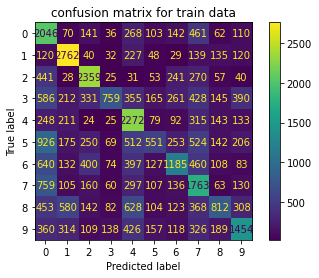

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
label_train_f =np.concatenate( label_train, axis=0 )
predicted_train_f = np.concatenate( predict_train, axis=0 )

acc_train = accuracy_score(label_train_f,predicted_train_f)
f1_train = f1_score(label_train_f, predicted_train_f, average="micro")
f1_train_macro = f1_score(label_train_f, predicted_train_f, average="macro")


print(f"accuracy score on train data: {acc_train}")
print(f"f1 score(micro) on train data: {f1_train}")
print(f"f1 score(macro) on train data: {f1_train_macro}")
print(f"cross entropy loss on train data:{loss/len(label_train_f)}")
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_train_f, predicted_train_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for train data')

**important note:** there is difference between accuracy when we trained on train data and when evaluated on it, it is because we are in .eval()
mode! so there is no dropout (and other things that implemented in the transformer) so we achive higher accuracy.

also, In classification tasks for which every test case is guaranteed to be assigned to exactly one class, micro-F is equivalent to accuracy so because of that they are the same here but you can see there is difference in f1 score in macro mode


for validation

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_linear_tune.eval()
label_val = []
predict_val = []
criterion = nn.CrossEntropyLoss()
loss = 0
with torch.inference_mode():
  for dl in tqdm(valid_data_loader, total=len(valid_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_linear_tune(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    label_val.append(targets.cpu().detach().numpy())
    predict_val.append(preds.cpu().detach().numpy())
    loss_val= criterion(outputs, targets.data)
    loss = loss + loss_val

Calculating Train Lables... : 100%|██████████| 249/249 [00:07<00:00, 31.81it/s]


accuracy score on validation data: 0.44167923579688284
f1 score (micro) on validation data: 0.4416792357968828
f1 score (macro) on validation data: 0.42175568227106713
cross entropy loss on validation data:0.1019061729311943


Text(0.5, 1.0, 'confusion matrix for validation data')

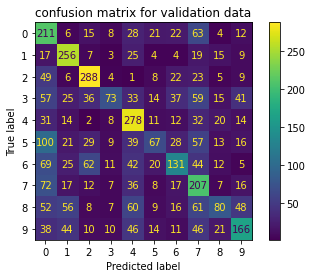

In [ ]:
label_val_f =np.concatenate( label_val, axis=0 )
predicted_val_f = np.concatenate( predict_val, axis=0 )

acc_train = accuracy_score(label_val_f,predicted_val_f)
f1_train = f1_score(label_val_f, predicted_val_f, average="micro")
f1_train_macro = f1_score(label_val_f, predicted_val_f, average="macro")


print(f"accuracy score on validation data: {acc_train}")
print(f"f1 score (micro) on validation data: {f1_train}")
print(f"f1 score (macro) on validation data: {f1_train_macro}")
print(f"cross entropy loss on validation data:{loss/len(label_val_f)}")

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_val_f, predicted_val_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for validation data')

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_linear_tune.eval()
label_test = []
predict_test = []
criterion = nn.CrossEntropyLoss()
loss = 0
with torch.inference_mode():
  for dl in tqdm(test_data_loader, total=len(test_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_linear_tune(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    label_test.append(targets.cpu().detach().numpy())
    predict_test.append(preds.cpu().detach().numpy())
    loss_test= criterion(outputs, targets.data)
    loss = loss + loss_test

Calculating Train Lables... : 100%|██████████| 622/622 [00:19<00:00, 32.21it/s]


accuracy score on test data: 0.4358407079646018
f1 score (micro) on test data: 0.4358407079646018
f1 score (macro) on test data: 0.41479174766707355
cross entropy loss on test data:0.10121414810419083


Text(0.5, 1.0, 'confusion matrix for test data')

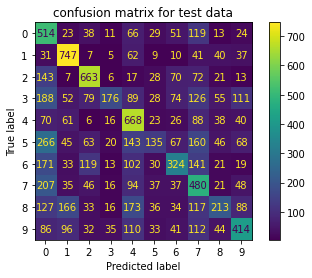

In [ ]:
label_test_f =np.concatenate( label_test, axis=0 )
predicted_test_f = np.concatenate( predict_test, axis=0 )

acc= accuracy_score(label_test_f,predicted_test_f)
f1 = f1_score(label_test_f, predicted_test_f, average="micro")
f1_macro = f1_score(label_test_f, predicted_test_f, average="macro")


print(f"accuracy score on test data: {acc}")
print(f"f1 score (micro) on test data: {f1}")
print(f"f1 score (macro) on test data: {f1_macro}")
print(f"cross entropy loss on test data:{loss/len(label_test_f)}")

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_test_f, predicted_test_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for test data')

as we can see, in eval mode for model all acuracies are around 0.44, which for 10 class classification is not bad! 

### Part B: Fine tuning whole model

we wrote our model creator function in previous part in a way that we can easilly make transformer trainable(we added parameter fine_tune to written class, so if we give true as input, it doesn't make transformer weights untrainable, so the whole model will be in fine-tuning process:


In [ ]:
class Poet_Bert_classifier(nn.Module):

    def __init__(self, config,MODEL_NAME_OR_PATH,fine_tune):
        super(Poet_Bert_classifier, self).__init__()

        bert_model = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        if (fine_tune):
          self.bert = bert_model
        else:
          for param in bert_model.parameters():
            param.requires_grad = False
          self.bert = bert_model
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, token_type_ids=token_type_ids,return_dict=False)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 


so we just have to call our class and use true for fine-tune parameter

In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

print('pt_model', type(pt_model_fine_tune))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


In [ ]:
pytorch_total_params = sum(p.numel() for p in pt_model_fine_tune.parameters())
print(f"number of all parameters in model {pytorch_total_params}")
pytorch_total_params = sum(p.numel() for p in pt_model_fine_tune.parameters() if p.requires_grad)
print(f"number of trainable parameters in model {pytorch_total_params}")


number of all parameters in model 162849034
number of trainable parameters in model 162849034


As we can see, all parameters are trainable, so in this case we fine-tune whole network

In [29]:
def train_model_manual(model, criterion, optimizer,scheduler,val_beark,clip,len_train,len_val, num_epochs=25):
  """
  function for train our model! in this function we use dataloader directly.
  inputs: 
      model: input model 
      criterion: desired loss function
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
      clip: for gradient clipping
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for dl in tqdm(train_data_loader, total=len(train_data_loader), desc="Training... "):
      # 1. Forward pass
      input_ids = dl['input_ids']
      attention_mask = dl['attention_mask']
      token_type_ids = dl['token_type_ids']
      targets = dl['targets']
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      token_type_ids = token_type_ids.to(device)
      targets = targets.to(device)
 
      outputs = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = criterion(outputs, targets)
      acc_train += torch.sum(preds == targets.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()
      if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/counter
    acc_train = acc_train/len_train
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for dl in tqdm(valid_data_loader, total=len(valid_data_loader), desc="Validating... "):
      # 1. Forward pass
        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
        _, preds = torch.max(outputs, 1)
        loss_test= criterion(outputs, targets.data)
        acc_test += torch.sum(preds == targets.data)
      loss_test = loss_test/counter
      acc_test = acc_test/len_val
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


first we train with SGD, and then we use Adam

In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(pt_model_fine_tune.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_trained_tune_sgd,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=7)

Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.15it/s]


Epoch: 0 | Loss: 1.56912, Acc: 0.45% | Test Loss: 1.09755, Test Acc: 0.60%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.17it/s]


Epoch: 1 | Loss: 1.05854, Acc: 0.63% | Test Loss: 0.84867, Test Acc: 0.64%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.16it/s]


Epoch: 2 | Loss: 0.80304, Acc: 0.72% | Test Loss: 0.34281, Test Acc: 0.72%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.20it/s]


Epoch: 3 | Loss: 0.63137, Acc: 0.78% | Test Loss: 0.43469, Test Acc: 0.73%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.22it/s]


Epoch: 4 | Loss: 0.48692, Acc: 0.83% | Test Loss: 0.23682, Test Acc: 0.75%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.10it/s]


Epoch: 5 | Loss: 0.37661, Acc: 0.87% | Test Loss: 0.85255, Test Acc: 0.73%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.12it/s]


Epoch: 6 | Loss: 0.29617, Acc: 0.90% | Test Loss: 0.72639, Test Acc: 0.77%
Training complete in 27m 16s
Best val Acc: 0.765209


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(pt_model_trained_tune_sgd.state_dict(), '/content/drive/MyDrive/models_HW04/sgd_bert')


In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_sgd.eval()
criterion = nn.CrossEntropyLoss()
loss = 0
label_train = []

predict_train = []
with torch.inference_mode():
  for dl in tqdm(train_data_loader, total=len(train_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_sgd(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    loss_train= criterion(outputs, targets.data)
    loss = loss + loss_train
    label_train.append(targets.cpu().detach().numpy())
    predict_train.append(preds.cpu().detach().numpy())

Calculating Train Lables... : 100%|██████████| 2238/2238 [01:09<00:00, 32.18it/s]


fine tuning whole model (SGD)


accuracy score on train data: 0.9644643106579132
f1 score(micro) on train data: 0.9644643106579132
f1 score(macro) on train data: 0.9643889708089199
cross entropy loss on train data:0.006877807900309563


Text(0.5, 1.0, 'confusion matrix for train data')

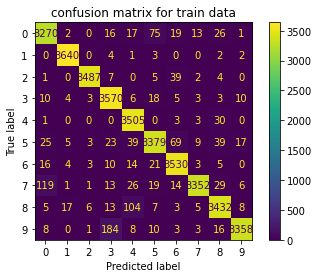

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
label_train_f =np.concatenate( label_train, axis=0 )
predicted_train_f = np.concatenate( predict_train, axis=0 )

acc_train = accuracy_score(label_train_f,predicted_train_f)
f1_train = f1_score(label_train_f, predicted_train_f, average="micro")
f1_train_macro = f1_score(label_train_f, predicted_train_f, average="macro")

print('fine tuning whole model (SGD)')
print('\n')
print(f"accuracy score on train data: {acc_train}")
print(f"f1 score(micro) on train data: {f1_train}")
print(f"f1 score(macro) on train data: {f1_train_macro}")
print(f"cross entropy loss on train data:{loss/len(label_train_f)}")
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_train_f, predicted_train_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for train data')

as we said before, difference between result of train accuracy when training model and after it has finished is because of it's mode, when in the end we want to report final output we use model.eval() so there is no dropout and other things like that so we have a huge boost in performance for train data, but as you can see below, score for validation is exactly the same because we reported it's value in eval mode so there is no difference

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_sgd.eval()
label_val = []
predict_val = []
criterion = nn.CrossEntropyLoss()
loss = 0
with torch.inference_mode():
  for dl in tqdm(valid_data_loader, total=len(valid_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_sgd(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    label_val.append(targets.cpu().detach().numpy())
    predict_val.append(preds.cpu().detach().numpy())
    loss_val= criterion(outputs, targets.data)
    loss = loss + loss_val

Calculating Train Lables... : 100%|██████████| 249/249 [00:07<00:00, 31.86it/s]


fine tuning whole model (SGD)


accuracy score on validation data: 0.7652086475615887
f1 score (micro) on validation data: 0.7652086475615887
f1 score (macro) on validation data: 0.7649364659147527
cross entropy loss on validation data:0.05095747485756874


Text(0.5, 1.0, 'confusion matrix for validation data')

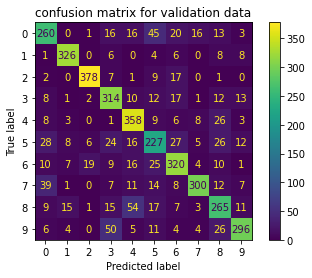

In [ ]:
label_val_f =np.concatenate( label_val, axis=0 )
predicted_val_f = np.concatenate( predict_val, axis=0 )

acc_train = accuracy_score(label_val_f,predicted_val_f)
f1_train = f1_score(label_val_f, predicted_val_f, average="micro")
f1_train_macro = f1_score(label_val_f, predicted_val_f, average="macro")

print('fine tuning whole model (SGD)')
print('\n')
print(f"accuracy score on validation data: {acc_train}")
print(f"f1 score (micro) on validation data: {f1_train}")
print(f"f1 score (macro) on validation data: {f1_train_macro}")
print(f"cross entropy loss on validation data:{loss/len(label_val_f)}")

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_val_f, predicted_val_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for validation data')

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_sgd.eval()
label_test = []
predict_test = []
criterion = nn.CrossEntropyLoss()
loss = 0
with torch.inference_mode():
  for dl in tqdm(test_data_loader, total=len(test_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_sgd(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    label_test.append(targets.cpu().detach().numpy())
    predict_test.append(preds.cpu().detach().numpy())
    loss_test= criterion(outputs, targets.data)
    loss = loss + loss_test

Calculating Train Lables... : 100%|██████████| 622/622 [00:20<00:00, 30.91it/s]


fine tuning whole model (SGD)


accuracy score on test data: 0.7642799678197908
f1 score (micro) on test data: 0.7642799678197908
f1 score (macro) on test data: 0.7619809759794667
cross entropy loss on test data:0.05093097314238548


Text(0.5, 1.0, 'confusion matrix for test data')

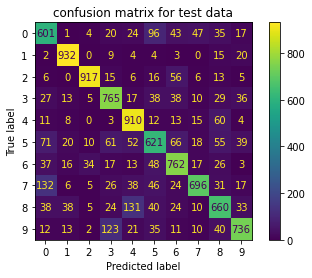

In [ ]:
label_test_f =np.concatenate( label_test, axis=0 )
predicted_test_f = np.concatenate( predict_test, axis=0 )

acc= accuracy_score(label_test_f,predicted_test_f)
f1 = f1_score(label_test_f, predicted_test_f, average="micro")
f1_macro = f1_score(label_test_f, predicted_test_f, average="macro")


print('fine tuning whole model (SGD)')
print('\n')
print(f"accuracy score on test data: {acc}")
print(f"f1 score (micro) on test data: {f1}")
print(f"f1 score (macro) on test data: {f1_macro}")
print(f"cross entropy loss on test data:{loss/len(label_test_f)}")

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_test_f, predicted_test_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for test data')

now we use Adam optimizer

In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

print('pt_model', type(pt_model_fine_tune))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.Adam(pt_model_fine_tune.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_trained_tune_adam,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=5)

Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.73it/s]


Epoch: 0 | Loss: 2.44597, Acc: 0.10% | Test Loss: 2.49279, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.80it/s]


Epoch: 1 | Loss: 2.44301, Acc: 0.10% | Test Loss: 2.48246, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.83it/s]


Epoch: 2 | Loss: 2.44124, Acc: 0.10% | Test Loss: 2.50837, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.79it/s]


Epoch: 3 | Loss: 2.44278, Acc: 0.10% | Test Loss: 2.44809, Test Acc: 0.11%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.72it/s]


Epoch: 4 | Loss: 2.43600, Acc: 0.10% | Test Loss: 2.39012, Test Acc: 0.10%
Training complete in 24m 55s
Best val Acc: 0.105832


as we can see, when using adam it stuck in a local minimum(all random, we have 10 class so random probability is 0.1, which is our model accuracy) it's because adam use higher order gradient (estimation of hessian matrix) so it's more stable, but easier to stuck!(in sgd we have more aggresive approch, so it's easier to get out of this local points but more unstable) first lets plot confusion matrix and report it f1 score

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_adam.eval()
criterion = nn.CrossEntropyLoss()
loss = 0
label_train = []

predict_train = []
with torch.inference_mode():
  for dl in tqdm(train_data_loader, total=len(train_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_adam(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    loss_train= criterion(outputs, targets.data)
    loss = loss + loss_train
    label_train.append(targets.cpu().detach().numpy())
    predict_train.append(preds.cpu().detach().numpy())

Calculating Train Lables... : 100%|██████████| 2238/2238 [01:18<00:00, 28.41it/s]


fine tuning whole model (Adam)


accuracy score on train data: 0.10074032686129347
f1 score(micro) on train data: 0.10074032686129347
f1 score(macro) on train data: 0.018304103956752367
cross entropy loss on train data:0.15154102444648743


Text(0.5, 1.0, 'confusion matrix for train data')

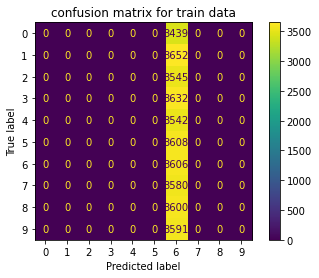

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
label_train_f =np.concatenate( label_train, axis=0 )
predicted_train_f = np.concatenate( predict_train, axis=0 )

acc_train = accuracy_score(label_train_f,predicted_train_f)
f1_train = f1_score(label_train_f, predicted_train_f, average="micro")
f1_train_macro = f1_score(label_train_f, predicted_train_f, average="macro")

print('fine tuning whole model (Adam)')
print('\n')
print(f"accuracy score on train data: {acc_train}")
print(f"f1 score(micro) on train data: {f1_train}")
print(f"f1 score(macro) on train data: {f1_train_macro}")
print(f"cross entropy loss on train data:{loss/len(label_train_f)}")
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_train_f, predicted_train_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for train data')

it literally give all inputs same label!

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_adam.eval()
label_val = []
predict_val = []
criterion = nn.CrossEntropyLoss()
loss = 0
with torch.inference_mode():
  for dl in tqdm(valid_data_loader, total=len(valid_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_adam(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    label_val.append(targets.cpu().detach().numpy())
    predict_val.append(preds.cpu().detach().numpy())
    loss_val= criterion(outputs, targets.data)
    loss = loss + loss_val

Calculating Train Lables... : 100%|██████████| 249/249 [00:10<00:00, 24.89it/s]


fine tuning whole model (Adam)


accuracy score on validation data: 0.10583207642031171
f1 score (micro) on validation data: 0.10583207642031171
f1 score (macro) on validation data: 0.019140713798590586
cross entropy loss on validation data:0.1523279845714569


Text(0.5, 1.0, 'confusion matrix for validation data')

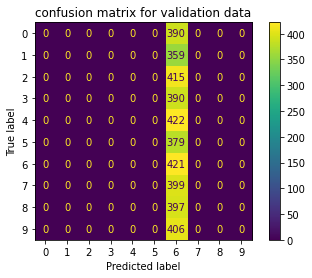

In [ ]:
label_val_f =np.concatenate( label_val, axis=0 )
predicted_val_f = np.concatenate( predict_val, axis=0 )

acc_train = accuracy_score(label_val_f,predicted_val_f)
f1_train = f1_score(label_val_f, predicted_val_f, average="micro")
f1_train_macro = f1_score(label_val_f, predicted_val_f, average="macro")

print('fine tuning whole model (Adam)')
print('\n')
print(f"accuracy score on validation data: {acc_train}")
print(f"f1 score (micro) on validation data: {f1_train}")
print(f"f1 score (macro) on validation data: {f1_train_macro}")
print(f"cross entropy loss on validation data:{loss/len(label_val_f)}")

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_val_f, predicted_val_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for validation data')

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_adam.eval()
label_test = []
predict_test = []
criterion = nn.CrossEntropyLoss()
loss = 0
with torch.inference_mode():
  for dl in tqdm(test_data_loader, total=len(test_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_adam(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    label_test.append(targets.cpu().detach().numpy())
    predict_test.append(preds.cpu().detach().numpy())
    loss_test= criterion(outputs, targets.data)
    loss = loss + loss_test

Calculating Train Lables... : 100%|██████████| 622/622 [00:19<00:00, 31.11it/s]


fine tuning whole model (SGD)


accuracy score on test data: 0.09784794851166533
f1 score (micro) on test data: 0.09784794851166534
f1 score (macro) on test data: 0.01782540991114775
cross entropy loss on test data:0.15193811058998108


Text(0.5, 1.0, 'confusion matrix for test data')

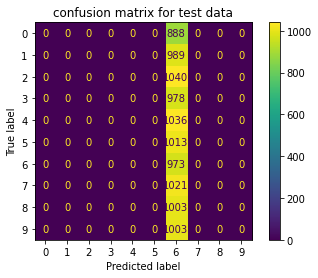

In [ ]:
label_test_f =np.concatenate( label_test, axis=0 )
predicted_test_f = np.concatenate( predict_test, axis=0 )

acc= accuracy_score(label_test_f,predicted_test_f)
f1 = f1_score(label_test_f, predicted_test_f, average="micro")
f1_macro = f1_score(label_test_f, predicted_test_f, average="macro")


print('fine tuning whole model (SGD)')
print('\n')
print(f"accuracy score on test data: {acc}")
print(f"f1 score (micro) on test data: {f1}")
print(f"f1 score (macro) on test data: {f1_macro}")
print(f"cross entropy loss on test data:{loss/len(label_test_f)}")

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_test_f, predicted_test_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for test data')

so how we can overcome this obstecle? easy! we use SGD and train model just for one epoch so model is not totally random and in a good track and then train with adam

In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)


criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(pt_model_fine_tune.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_fine_tune,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=1)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.08it/s]


Epoch: 0 | Loss: 1.61177, Acc: 0.43% | Test Loss: 1.24169, Test Acc: 0.54%
Training complete in 3m 58s
Best val Acc: 0.542484


In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.Adam(pt_model_fine_tune.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_trained_tune_adam,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=5)

Validating... : 100%|██████████| 249/249 [00:06<00:00, 40.10it/s]


Epoch: 0 | Loss: 3.57591, Acc: 0.10% | Test Loss: 2.63200, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 40.00it/s]


Epoch: 1 | Loss: 3.50783, Acc: 0.10% | Test Loss: 3.53708, Test Acc: 0.11%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 40.15it/s]


Epoch: 2 | Loss: 3.57745, Acc: 0.10% | Test Loss: 3.47295, Test Acc: 0.11%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 40.13it/s]


Epoch: 3 | Loss: 3.50821, Acc: 0.10% | Test Loss: 3.53198, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 40.12it/s]


Epoch: 4 | Loss: 3.55380, Acc: 0.10% | Test Loss: 3.23529, Test Acc: 0.11%
Training complete in 24m 36s
Best val Acc: 0.106083


so it looks like we didn't train model enough with sgd! lets try to train for tree epoches and then feed it to adam

In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)


criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(pt_model_fine_tune.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_fine_tune_initial,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=3)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.25it/s]


Epoch: 0 | Loss: 1.55912, Acc: 0.45% | Test Loss: 1.08052, Test Acc: 0.57%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.06it/s]


Epoch: 1 | Loss: 1.05247, Acc: 0.64% | Test Loss: 0.56960, Test Acc: 0.64%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 38.22it/s]


Epoch: 2 | Loss: 0.79686, Acc: 0.72% | Test Loss: 1.05942, Test Acc: 0.66%
Training complete in 11m 44s
Best val Acc: 0.661890


In [ ]:
criterion = nn.CrossEntropyLoss()

pt_model_fine_tune_initial = pt_model_fine_tune_initial.to(device)
optimizer_conv = optim.Adam(pt_model_fine_tune_initial.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_fine_tune_initial_sgd_adam,best_loss,best_acc = train_model_manual(pt_model_fine_tune_initial, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=3)

Validating... : 100%|██████████| 249/249 [00:06<00:00, 40.07it/s]


Epoch: 0 | Loss: 2.52806, Acc: 0.10% | Test Loss: 2.52150, Test Acc: 0.09%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 40.13it/s]


Epoch: 1 | Loss: 2.49004, Acc: 0.10% | Test Loss: 2.37011, Test Acc: 0.11%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 40.14it/s]


Epoch: 2 | Loss: 2.47020, Acc: 0.10% | Test Loss: 2.31082, Test Acc: 0.10%
Training complete in 14m 52s
Best val Acc: 0.105832


so even we give model head start, it coverge to a bad result when using adam, lets try another lr 

In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

print('pt_model', type(pt_model_fine_tune))
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.Adam(pt_model_fine_tune.parameters(), lr=0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_trained_tune_adam,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=5)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


Validating... : 100%|██████████| 249/249 [00:06<00:00, 41.20it/s]


Epoch: 0 | Loss: 31.26943, Acc: 0.10% | Test Loss: 17.95770, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 41.29it/s]


Epoch: 1 | Loss: 29.61175, Acc: 0.10% | Test Loss: 44.46133, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 41.22it/s]


Epoch: 2 | Loss: 29.25966, Acc: 0.10% | Test Loss: 33.69293, Test Acc: 0.11%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 41.23it/s]


Epoch: 3 | Loss: 28.72706, Acc: 0.10% | Test Loss: 11.07724, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 41.25it/s]


Epoch: 4 | Loss: 30.38138, Acc: 0.10% | Test Loss: 43.75602, Test Acc: 0.11%
Training complete in 24m 2s
Best val Acc: 0.109100


In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

print('pt_model', type(pt_model_fine_tune))
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.Adam(pt_model_fine_tune.parameters(), lr=1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_trained_tune_adam,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=5)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


Validating... : 100%|██████████| 249/249 [00:05<00:00, 41.77it/s]


Epoch: 0 | Loss: 308.44058, Acc: 0.10% | Test Loss: 431.87656, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:05<00:00, 41.70it/s]


Epoch: 1 | Loss: 290.00778, Acc: 0.10% | Test Loss: 237.90903, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:05<00:00, 41.75it/s]


Epoch: 2 | Loss: 297.02570, Acc: 0.10% | Test Loss: 213.20496, Test Acc: 0.09%


Validating... : 100%|██████████| 249/249 [00:05<00:00, 41.73it/s]


Epoch: 3 | Loss: 300.38699, Acc: 0.10% | Test Loss: 574.50665, Test Acc: 0.11%


Validating... : 100%|██████████| 249/249 [00:05<00:00, 41.69it/s]


Epoch: 4 | Loss: 313.02524, Acc: 0.10% | Test Loss: 343.70135, Test Acc: 0.11%
Training complete in 24m 0s
Best val Acc: 0.105078


In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

print('pt_model', type(pt_model_fine_tune))
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.Adam(pt_model_fine_tune.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_trained_tune_adam,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=5)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.92it/s]


Epoch: 0 | Loss: 2.30666, Acc: 0.11% | Test Loss: 2.23612, Test Acc: 0.11%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.97it/s]


Epoch: 1 | Loss: 2.32988, Acc: 0.10% | Test Loss: 2.25181, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.93it/s]


Epoch: 2 | Loss: 2.32867, Acc: 0.10% | Test Loss: 2.34261, Test Acc: 0.11%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.90it/s]


Epoch: 3 | Loss: 2.32730, Acc: 0.10% | Test Loss: 2.34490, Test Acc: 0.10%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 39.85it/s]


Epoch: 4 | Loss: 2.32784, Acc: 0.10% | Test Loss: 2.28832, Test Acc: 0.10%
Training complete in 24m 38s
Best val Acc: 0.109351


so when using Adam,we couldn't make it to work! and it always converged to a really bad local minimum (all random).
for trying to get better results, we tried to initialize model with SGD (which we showed that could achive high accuracy (76%) ) but it didn't work, we also tried to achive better result by changing learning rate but it didn't work either.
so lets train model with sgd again for next part

In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

print('pt_model', type(pt_model_fine_tune))
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(pt_model_fine_tune.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_trained_tune_sgd,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=7)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.Poet_Bert_classifier'>


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.35it/s]


Epoch: 0 | Loss: 1.84598, Acc: 0.35% | Test Loss: 1.42099, Test Acc: 0.50%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 35.74it/s]


Epoch: 1 | Loss: 1.37505, Acc: 0.52% | Test Loss: 1.61255, Test Acc: 0.43%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 35.71it/s]


Epoch: 2 | Loss: 1.14391, Acc: 0.60% | Test Loss: 1.02185, Test Acc: 0.58%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.30it/s]


Epoch: 3 | Loss: 0.98841, Acc: 0.66% | Test Loss: 0.95753, Test Acc: 0.64%


Validating... : 100%|██████████| 249/249 [00:06<00:00, 35.78it/s]


Epoch: 4 | Loss: 0.86908, Acc: 0.70% | Test Loss: 1.08703, Test Acc: 0.62%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.54it/s]


Epoch: 5 | Loss: 0.76251, Acc: 0.73% | Test Loss: 1.11364, Test Acc: 0.59%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 33.20it/s]


Epoch: 6 | Loss: 0.67838, Acc: 0.76% | Test Loss: 1.42440, Test Acc: 0.57%
Training complete in 25m 7s
Best val Acc: 0.636249


In [ ]:
torch.save(pt_model_trained_tune_sgd.state_dict(), '/content/drive/MyDrive/models_HW04/sgd_bert')


In [ ]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

pt_model_fine_tune.load_state_dict(torch.load('/content/drive/MyDrive/models_HW04/sgd_bert'))
criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(pt_model_fine_tune.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.5)

pt_model_fine_tune = pt_model_fine_tune.to(device)
pt_model_trained_tune_sgd,best_loss,best_acc = train_model_manual(pt_model_fine_tune, criterion, optimizer_conv,exp_lr_scheduler,20,0.0,len(X_train),len(X_valid),num_epochs=7)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.28it/s]


Epoch: 0 | Loss: 0.60509, Acc: 0.79% | Test Loss: 2.53901, Test Acc: 0.43%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.46it/s]


Epoch: 1 | Loss: 0.53749, Acc: 0.81% | Test Loss: 0.54619, Test Acc: 0.73%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.37it/s]


Epoch: 2 | Loss: 0.46398, Acc: 0.84% | Test Loss: 0.59616, Test Acc: 0.66%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.57it/s]


Epoch: 3 | Loss: 0.40300, Acc: 0.86% | Test Loss: 0.84501, Test Acc: 0.74%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.40it/s]


Epoch: 4 | Loss: 0.34376, Acc: 0.88% | Test Loss: 0.69646, Test Acc: 0.75%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.57it/s]


Epoch: 5 | Loss: 0.29516, Acc: 0.90% | Test Loss: 0.64536, Test Acc: 0.73%


Validating... : 100%|██████████| 249/249 [00:07<00:00, 35.49it/s]


Epoch: 6 | Loss: 0.25166, Acc: 0.91% | Test Loss: 0.40538, Test Acc: 0.76%
Training complete in 24m 58s
Best val Acc: 0.757164


In [ ]:
torch.save(pt_model_trained_tune_sgd.state_dict(), '/content/drive/MyDrive/models_HW04/sgd_bert')


Calculating Train Lables... : 100%|██████████| 2238/2238 [01:14<00:00, 29.92it/s]


fine tuning whole model (SGD)


accuracy score on train data: 0.9773432043581506
f1 score(micro) on train data: 0.9773432043581506
f1 score(macro) on train data: 0.977305950795136
cross entropy loss on train data:0.005701124202460051


Text(0.5, 1.0, 'confusion matrix for train data')

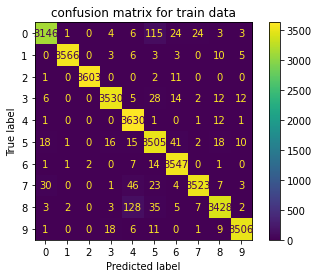

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_sgd.eval()
criterion = nn.CrossEntropyLoss()
loss = 0
label_train = []

predict_train = []
with torch.inference_mode():
  for dl in tqdm(train_data_loader, total=len(train_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_sgd(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    loss_train= criterion(outputs, targets.data)
    loss = loss + loss_train
    label_train.append(targets.cpu().detach().numpy())
    predict_train.append(preds.cpu().detach().numpy())
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
label_train_f =np.concatenate( label_train, axis=0 )
predicted_train_f = np.concatenate( predict_train, axis=0 )

acc_train = accuracy_score(label_train_f,predicted_train_f)
f1_train = f1_score(label_train_f, predicted_train_f, average="micro")
f1_train_macro = f1_score(label_train_f, predicted_train_f, average="macro")

print('fine tuning whole model (SGD)')
print('\n')
print(f"accuracy score on train data: {acc_train}")
print(f"f1 score(micro) on train data: {f1_train}")
print(f"f1 score(macro) on train data: {f1_train_macro}")
print(f"cross entropy loss on train data:{loss/len(label_train_f)}")
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_train_f, predicted_train_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for train data')

Calculating Train Lables... : 100%|██████████| 249/249 [00:06<00:00, 37.36it/s]


fine tuning whole model (SGD)


accuracy score on validation data: 0.7571644042232277
f1 score (micro) on validation data: 0.7571644042232277
f1 score (macro) on validation data: 0.7598156219986592
cross entropy loss on validation data:0.049694616347551346


Text(0.5, 1.0, 'confusion matrix for validation data')

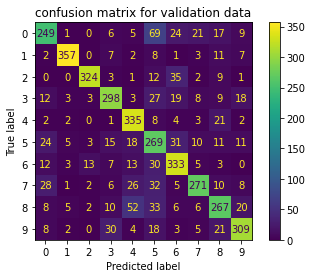

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_sgd.eval()
label_val = []
predict_val = []
criterion = nn.CrossEntropyLoss()
loss = 0
with torch.inference_mode():
  for dl in tqdm(valid_data_loader, total=len(valid_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_sgd(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    label_val.append(targets.cpu().detach().numpy())
    predict_val.append(preds.cpu().detach().numpy())
    loss_val= criterion(outputs, targets.data)
    loss = loss + loss_val
label_val_f =np.concatenate( label_val, axis=0 )
predicted_val_f = np.concatenate( predict_val, axis=0 )

acc_train = accuracy_score(label_val_f,predicted_val_f)
f1_train = f1_score(label_val_f, predicted_val_f, average="micro")
f1_train_macro = f1_score(label_val_f, predicted_val_f, average="macro")

print('fine tuning whole model (SGD)')
print('\n')
print(f"accuracy score on validation data: {acc_train}")
print(f"f1 score (micro) on validation data: {f1_train}")
print(f"f1 score (macro) on validation data: {f1_train_macro}")
print(f"cross entropy loss on validation data:{loss/len(label_val_f)}")

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_val_f, predicted_val_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for validation data')

Calculating Train Lables... : 100%|██████████| 622/622 [00:19<00:00, 31.84it/s]

fine tuning whole model (SGD)


accuracy score on test data: 0.7515084473049075
f1 score (micro) on test data: 0.7515084473049074
f1 score (macro) on test data: 0.7532371267549881
cross entropy loss on test data:0.05231581628322601


Text(0.5, 1.0, 'confusion matrix for test data')

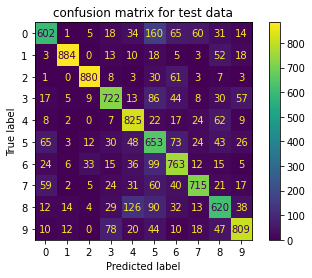

In [ ]:
# calculating labels for train,validation and test so we can calculate f1 score and plot confusion matrix
pt_model_trained_tune_sgd.eval()
label_test = []
predict_test = []
criterion = nn.CrossEntropyLoss()
loss = 0
with torch.inference_mode():
  for dl in tqdm(test_data_loader, total=len(test_data_loader), desc="Calculating Train Lables... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model_trained_tune_sgd(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    label_test.append(targets.cpu().detach().numpy())
    predict_test.append(preds.cpu().detach().numpy())
    loss_test= criterion(outputs, targets.data)
    loss = loss + loss_test
label_test_f =np.concatenate( label_test, axis=0 )
predicted_test_f = np.concatenate( predict_test, axis=0 )

acc= accuracy_score(label_test_f,predicted_test_f)
f1 = f1_score(label_test_f, predicted_test_f, average="micro")
f1_macro = f1_score(label_test_f, predicted_test_f, average="macro")


print('fine tuning whole model (SGD)')
print('\n')
print(f"accuracy score on test data: {acc}")
print(f"f1 score (micro) on test data: {f1}")
print(f"f1 score (macro) on test data: {f1_macro}")
print(f"cross entropy loss on test data:{loss/len(label_test_f)}")

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label_test_f, predicted_test_f)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.title('confusion matrix for test data')

## Calculatin Perplexity 

first, lets load model and replace last layer with identity function and test an input to see results

In [38]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

pt_model_fine_tune.load_state_dict(torch.load('/content/drive/MyDrive/models_HW04/sgd_bert'))
pt_model_fine_tune.eval()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Poet_Bert_classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


pt_model_fine_tune.classifier = Identity()

In [ ]:
dataset = poet_dataset(
        data=X_train,
        labels=y_train,
        tokenizer=tokenizer,
        max_len=MAX_LEN,)
sample_data = dataset[0]
print(sample_data['poet'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'])
print(sample_data['targets'].shape)
print(sample_data['targets'])
train_data_loader = DataLoader(dataset,batch_size = 1,shuffle = True)
sample_data = next(iter(train_data_loader))

input_ids = sample_data['input_ids']
attention_mask = sample_data['attention_mask']
token_type_ids = sample_data['token_type_ids']
targets = sample_data['targets']
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
token_type_ids = token_type_ids.to(device)
targets = targets.to(device)
outputs = pt_model_fine_tune(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
print(outputs.shape)

آنجا که بر آسمان پرد مردم نازش نسزد بر اشهب و ادهم
torch.Size([28])
tensor([    2,  4065,  2800,  2801,  6876,  3275,  3155,  7419,  2014,  3084,
         3181,  2801, 57294,  2016,  1379, 51766,     4,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])
torch.Size([28])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
torch.Size([28])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
torch.Size([])
tensor(8)
torch.Size([1, 768])


as we can see, output is shape of 768, which is hidden state units so we need real head for calculating output probabilities!

In [ ]:

encoding = tokenizer(X[0], return_tensors="pt")
encoding = encoding.to(device)
outputs = pt_model_fine_tune(**encoding)

for original model, we can use evaluate library to get output preploxity

In [40]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


we have shuffled X data, so if we choose first 1000 samples, they are in random order so we directly give them to evaluation model

In [48]:
from evaluate import load
perplexity = load("perplexity", module_type="metric")

input_texts = X[1:1000]
results = perplexity.compute(model_id= "HooshvareLab/bert-fa-base-uncased",
                             add_start_token=False,
                             predictions=input_texts)
print('\n')
print(f"mean perplexity = {results['mean_perplexity']}")

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/63 [00:00<?, ?it/s]



mean perplexity = 3269764.9991378095


now for fine tuned model

In [39]:
pt_model_fine_tune = Poet_Bert_classifier(config=config,MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased",fine_tune = True )
pt_model_fine_tune = pt_model_fine_tune.to(device)

pt_model_fine_tune.load_state_dict(torch.load('/content/drive/MyDrive/models_HW04/sgd_bert'))

pt_model_fine_tune.eval()
bert_fine_tune = pt_model_fine_tune.bert

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
bert_fine_tune.save_pretrained('/content/config_folder')
tokenizer.save_pretrained('/content/config_folder')
from evaluate import load
perplexity = load("perplexity", module_type="metric")

input_texts = X[1:1000]
results = perplexity.compute(model_id= "/content/config_folder",
                             add_start_token=False,
                             predictions=input_texts)
print('\n')
print(f"mean perplexity after fine-tuning = {results['mean_perplexity']}")

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of BertLMHeadModel were not initialized from the model checkpoint at /content/config_folder and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/63 [00:00<?, ?it/s]



mean perplexity after fine-tuning = 143795.32888357108


as we can see and expected, perplexity after fine-tuning model is much better that original model, because it is specialized on poem so it predict distribution of words better in this type of inputs.

if we want to calculate perplexity manually, we could easily define a function to calculate perplexity:
(soruce: https://huggingface.co/docs/transformers/perplexity with some modifications)

```
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids)
        outputs_loss = cross_entropy(target_ids,outputs)

        # loss is calculated using CrossEntropyLoss which averages over input tokens.
        # Multiply it with trg_len to get the summation instead of average.
        # We will take average over all the tokens to get the true average
        # in the last step of this example.
        neg_log_likelihood = outputs_loss.loss * trg_len

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).sum() / end_loc)

```
